## Linear denoiser

What's new:

* Enforcing toeplitz matrix
* Running denoiser for 7 channels
* Limiting max PTP for data covariance estimation

Next:

* Test FPR before/after
* TEst TPR before/after

In [1]:
USE_TOEPLITZ = True
CHANNELS = [0, 1]
MAX_PTP_FOR_COVARIANCE_ESTIMATION = 40
SAVE_RESULTS = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import lib_denoiser as lib

from collections import namedtuple
SpikeIndexes = namedtuple('SpikeIndexes', ['clean', 'all'])

from pathlib import Path
from collections import defaultdict

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot
from sklearn.covariance import EmpiricalCovariance, LedoitWolf

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.templates import util as templates_utl
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes
from yass.detect import nnet, nnet_experimental
from yass import preprocess

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model
import seaborn as sns

Using TensorFlow backend.


In [4]:
plt.rcParams['figure.figsize'] = (10, 10)

In [5]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

path_to_detector = '/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/detect_nn2.ckpt'

In [6]:
yass.set_config("../config/gcloud/49/default.yaml", 'noisy')
CONFIG = read_config()

In [7]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)

rec_all = RecordingsReader(path_to_standarized, loader='array').data

# (spatial_sig,
#  temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

rec_all.shape

(6000000, 49)

## Running detector in raw 49 channel data

In [8]:
detector = NeuralNetDetector.load(path_to_detector, 0.5, ch_idx)

(standarized_path,
 standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))

(index_clean_arr,
 index_all_arr) = nnet.run(standarized_path, standarized_params, whiten_filter,
                       'overwrite', False,
                        path_to_detector,
                        autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')

100%|██████████| 4595/4595 [00:34<00:00, 133.89it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


In [9]:
all_ = lib.SpikeIndex(index_all_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)
clean = lib.SpikeIndex(index_clean_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)

indexes_raw = SpikeIndexes(clean=clean, all=all_)

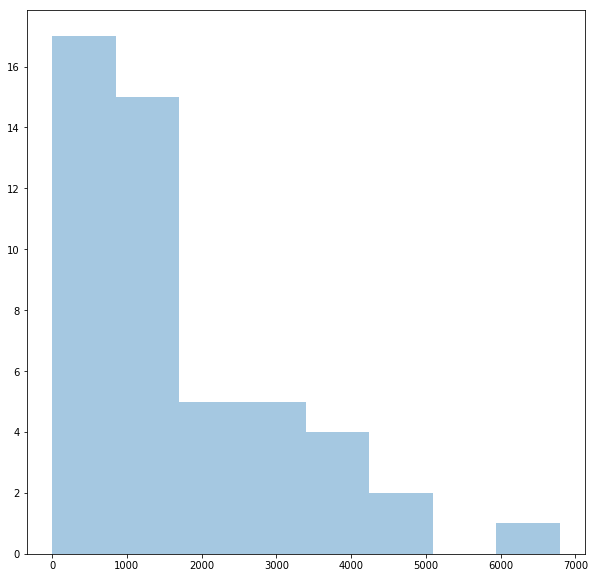

In [11]:
_ = indexes_raw.clean.count_spikes_per_channel()
sns.distplot(list(_.values()), kde=False, norm_hist=False)

## Load noise snippets from raw data for noise covariance estimation

In [12]:
def kill_signal_from_index(recordings, spike_index, window_size):
    """
    """
    recordings = np.copy(recordings)

    T, C = recordings.shape
    R = int((window_size-1)/2)

    # this will hold a flag 1 (noise), 0 (signal) for every obseration in the
    # recordings
    is_noise_idx = np.zeros((T, C))

    # go through every neighboring channel
    for c in range(C):

        # get indexes whose main channel is c
        idx_temp = spike_index[spike_index[:, 1] == c]

        # shift every index found
        for j in range(-R, R+1):

            # shift
            idx_temp2 = idx_temp + j

            # remove indexes outside range [0, T]
            idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >= 0,
                                                 idx_temp2 < T)]

            # set surviving indexes to nan
            recordings[idx_temp2, c] = np.nan

        is_signal_idx_temp = np.isnan(recordings[:, c])

        # standarize data, ignoring nans
#         recordings[:, c] = recordings[:, c]/np.nanstd(recordings[:, c])

        # set non noise indexes to 0 in the recordings
        recordings[is_signal_idx_temp, c] = 0

        # save noise indexes
        is_noise_idx[~is_signal_idx_temp, c] = 1

    return recordings, is_noise_idx

In [13]:
rec_with_nas, is_noise_idx = kill_signal_from_index(rec_all, indexes_raw.all.arr,
                                                    61)

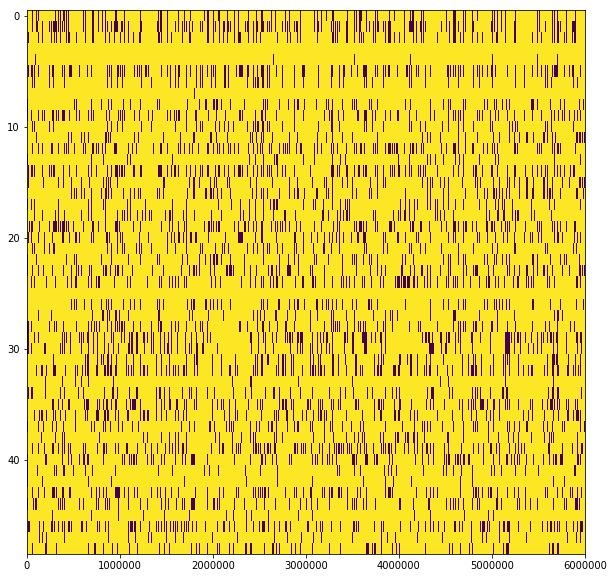

In [14]:
plt.imshow(is_noise_idx.T, aspect='auto')

In [15]:
noise_samples = noise_utils.search_noise_snippets(rec_with_nas, is_noise_idx, sample_size=20000,
                                          temporal_size=51, channel_choices=CONFIG.channel_index[[0], :7],
                                          max_trials_per_sample=1000,
                                          allow_smaller_sample_size=False)
noise_samples.shape

(20000, 51, 7)

In [16]:
def sample(rec, waveform_length, n):
    """Sample n waveforms of length waveform_length from recordings
    """
    min_idx = 0
    max_idx = rec.shape[0] - waveform_length

    idxs = np.random.randint(min_idx, max_idx, n)

    samples = np.empty((n, waveform_length, rec.shape[1]))

    for i, idx in enumerate(idxs):
        samples[i] = rec[i:i+waveform_length, :]
    
    return samples


def sample_noise(rec, waveform_length, n, detector, max_amplitude):
    """
    Sample n noise snippets of length waveform_length from recordings, pass them through a detector
    and remove the ones with > amplitude than max_amplitude
    """
    noise = np.empty((n, waveform_length, rec.shape[1]))
    remaining = n
    
    while remaining > 0:
        wfs = sample(rec, waveform_length, n)

        noise_detector_idx = ~ detector.predict(wfs).astype(bool)
        noise_amplitude_idx = augment_util.amplitudes(wfs) <= max_amplitude
        noise_idx = noise_detector_idx & noise_amplitude_idx

        noise_found = noise_idx.sum()

        idx_start = n - remaining
        idx_end = idx_start + noise_found
                
        if idx_end > n:
            idx_end = n

        noise[idx_start:idx_end] = wfs[noise_idx][:idx_end-idx_start, :]
        
        remaining -= noise_found
    
    return noise

In [17]:
# get noise samples from first channel neighbors,
# TODO: compute noise covariance per channel + neighbors
rec = rec_all[:, ch_idx[0]]
noise_samples = sample_noise(rec, 51, 20000, detector, 4)

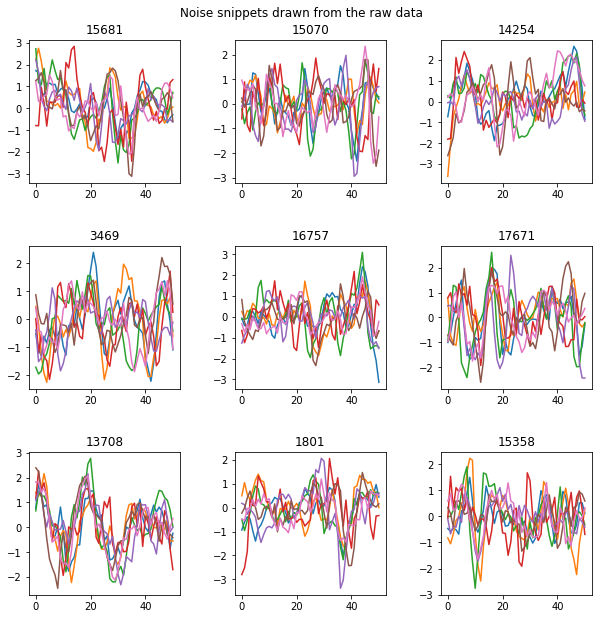

In [18]:
plot.grid_from_array(noise_samples, axis=0, elements=9, auto_figsize=3, auto_tight_layout=False)
_ = plt.suptitle('Noise snippets drawn from the raw data')
plt.tight_layout(pad=3)

## Compute the noise sample covariance using the noise snippets

In [19]:
noise_cov = (LedoitWolf(store_precision=False, assume_centered=False)
             .fit(noise_samples.reshape(noise_samples.shape[0], -1))).covariance_

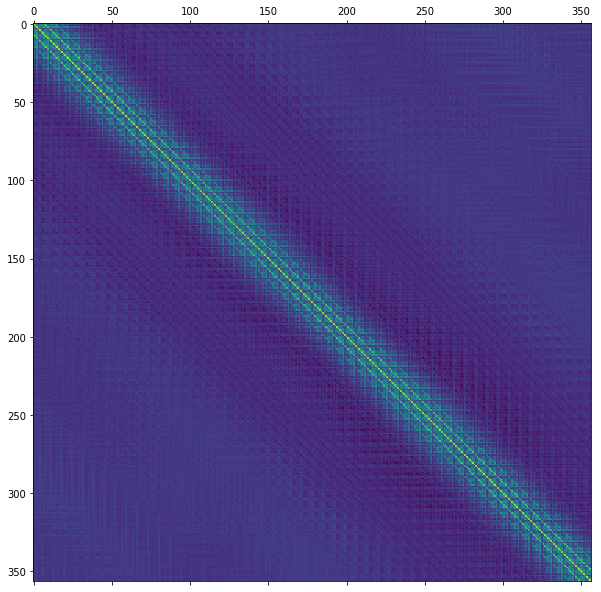

In [20]:
plt.matshow(noise_cov)

## Load spikes from the detector output but just the ones in the selected CHANNELS

In [21]:
# load waveforms for all spikes in the selected channels
spikes_all_dict = {}

for channel in CHANNELS:
    print(f'Getting spikes from channel {channel}...')
    spikes_all_dict[channel] = (indexes_raw.all
                                .read_waveforms_from_channel(rec_all,
                                                             channel=channel,
                                                             random_shift=False,
                                                             only_neighbors=True))

Getting spikes from channel 0...
Getting spikes from channel 1...


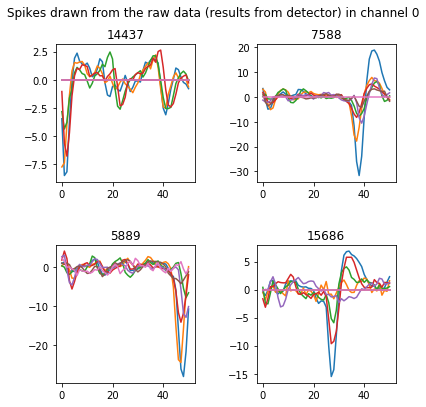

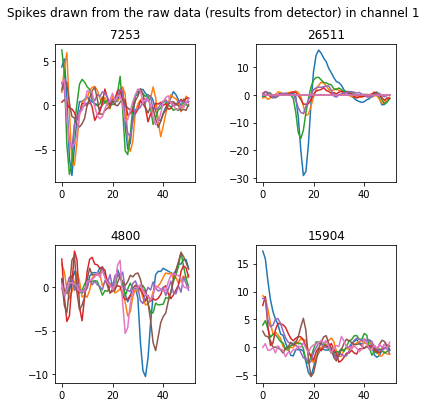

In [24]:
# FIXME: if the times the network returns are biased this will be bad...
for channel in CHANNELS:
    _ = spikes_all_dict[channel]
    plot.grid_from_array(_, axis=0, elements=4, auto_figsize=3)
    _ = plt.suptitle('Spikes drawn from the raw data (results from detector) in channel {}'.format(channel))
    plt.tight_layout(pad=3)

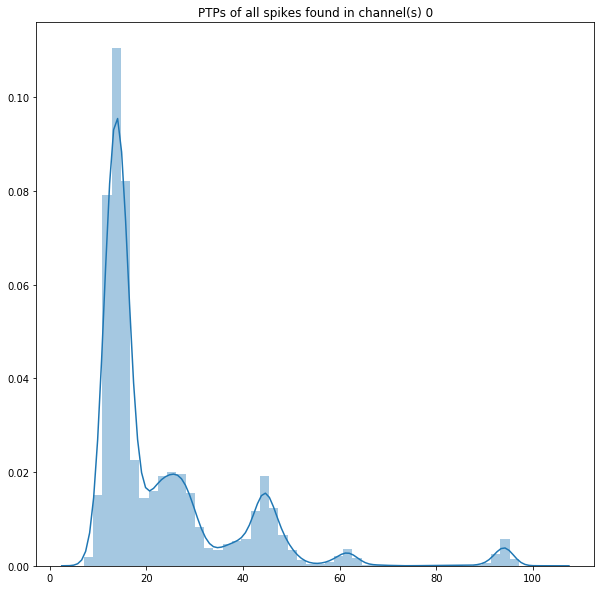

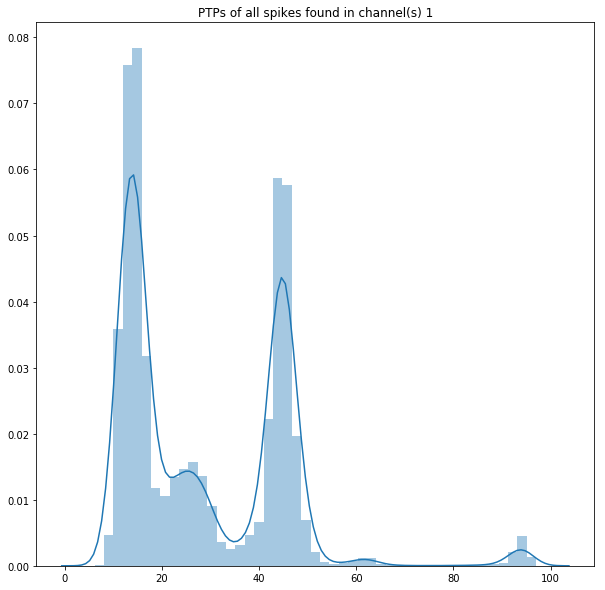

In [25]:
for channel in CHANNELS:
    _ = spikes_all_dict[channel]
    ptps = templates_utl.ptps(_)
    plt.figure()
    sns.distplot(ptps)
    _ = plt.title('PTPs of all spikes found in channel(s) {}'.format(channel))

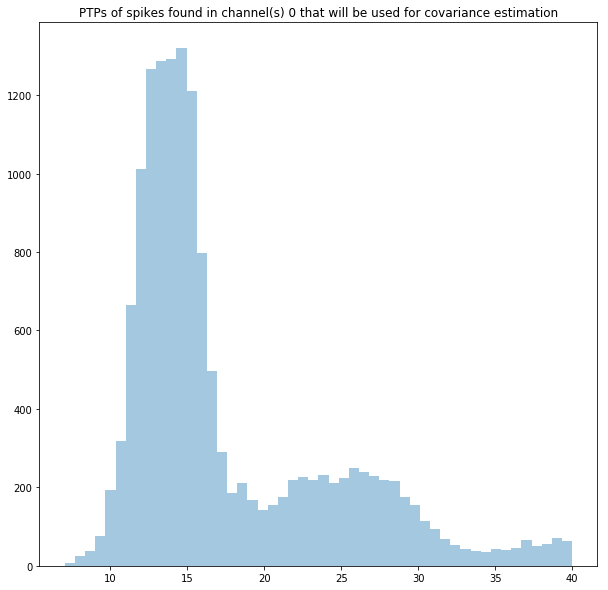

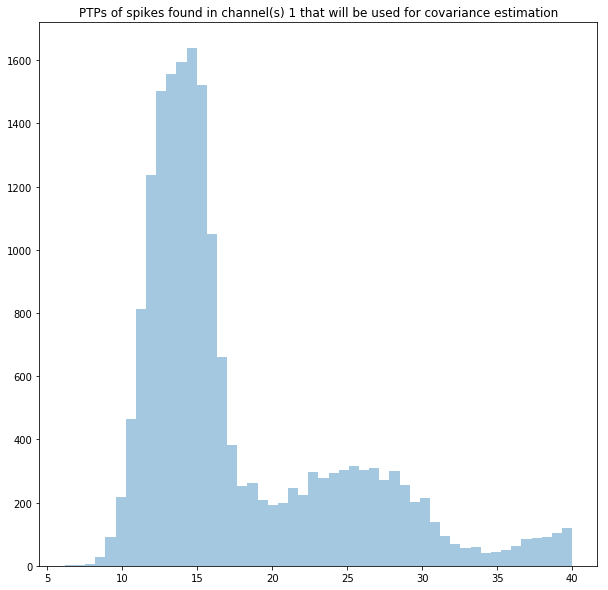

In [26]:
if MAX_PTP_FOR_COVARIANCE_ESTIMATION:
    spikes = dict()
    for channel in CHANNELS:
        current_spikes = spikes_all_dict[channel]
        ptps = templates_utl.ptps(current_spikes)
        spikes[channel] = current_spikes[ptps < MAX_PTP_FOR_COVARIANCE_ESTIMATION]
else:
    spikes = spikes_all_dict


for ch, sp in spikes.items():
    plt.figure()
    sns.distplot(templates_utl.ptps(sp), norm_hist=False, kde=False)
    _ = plt.title('PTPs of spikes found in channel(s) {} that will be used for covariance estimation'.format(ch))

## Compute the data sample covariance using the spikes snippets

In [27]:
spikes_cov = {}

for ch, sp in spikes.items():
    print('Computing covariance for channel {}'.format(ch))
    spikes_cov[ch] = (LedoitWolf(store_precision=False, assume_centered=True)
                           .fit(sp.reshape(sp.shape[0], -1))).covariance_

Computing covariance for channel 0
Computing covariance for channel 1


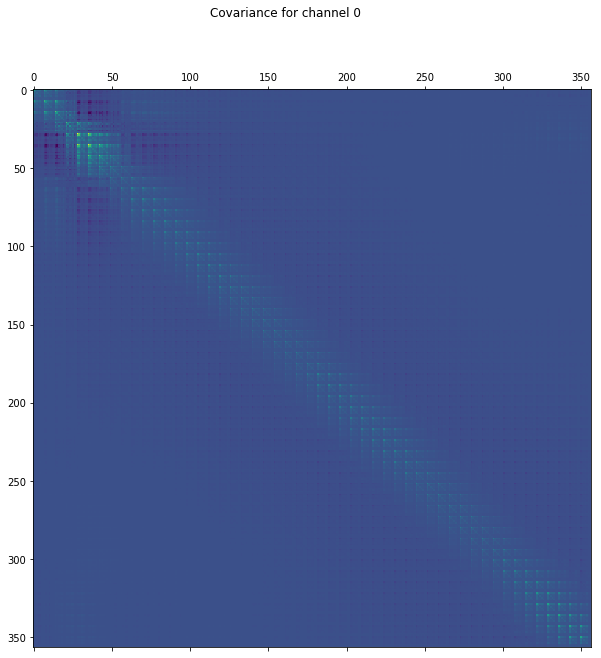

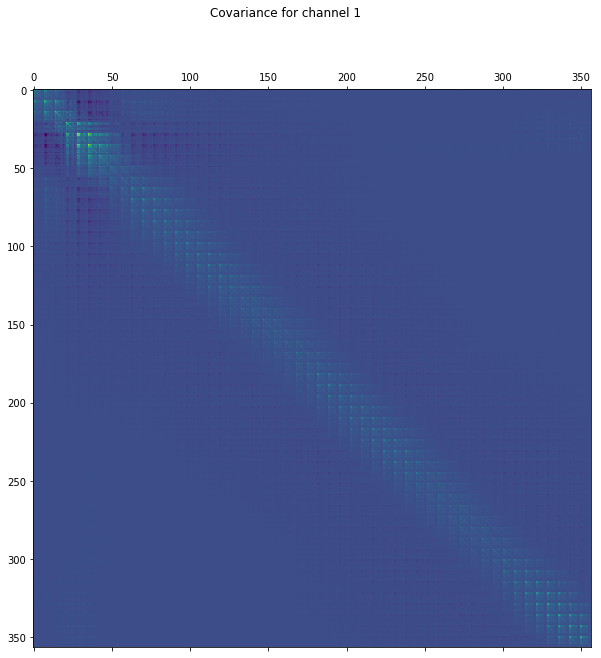

In [28]:
for ch, cov in spikes_cov.items():
    plt.matshow(cov)
    plt.suptitle('Covariance for channel {}'.format(ch))

## Signal covariance estimation

$$\Sigma_{signal} = \Sigma_{data} - \Sigma_{noise}$$

In [29]:
cx = {ch: cov - noise_cov for ch, cov in spikes_cov.items()}

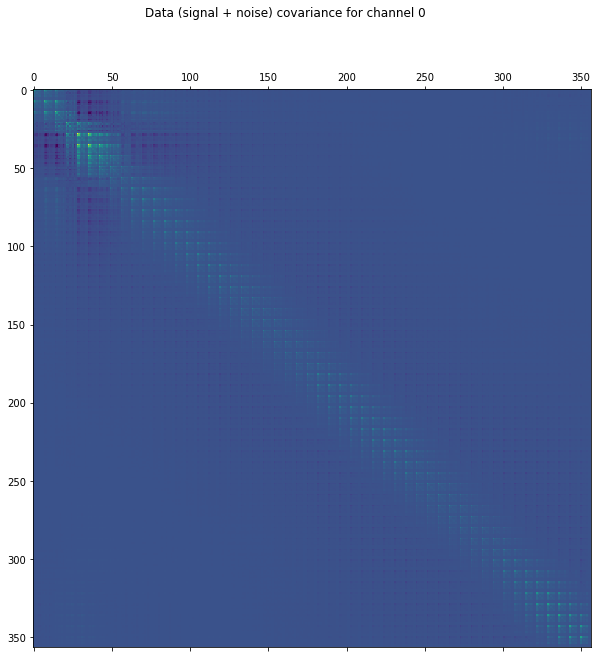

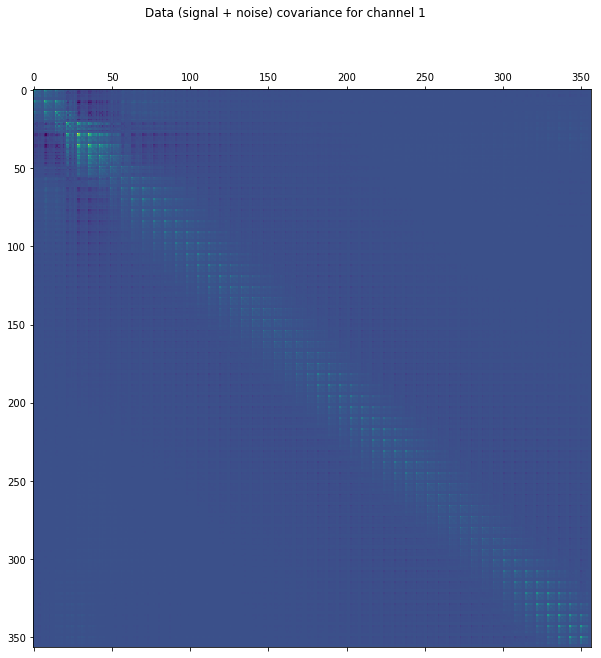

In [30]:
for ch, cov_sig in cx.items():
    plt.matshow(cov_sig)
    plt.suptitle('Data (signal + noise) covariance for channel {}'.format(ch))

## Compute optimal mapping

$$M = \Sigma_{data}^{-1} * \Sigma_{signal}$$

In [31]:
def compute_mapping(spikes_cov, cx):
    mapping = np.matmul(np.linalg.inv(spikes_cov), cx)
    return mapping

mapping = {}

for ch in spikes_cov.keys():
    mapping[ch] = compute_mapping(spikes_cov[ch], cx[ch])

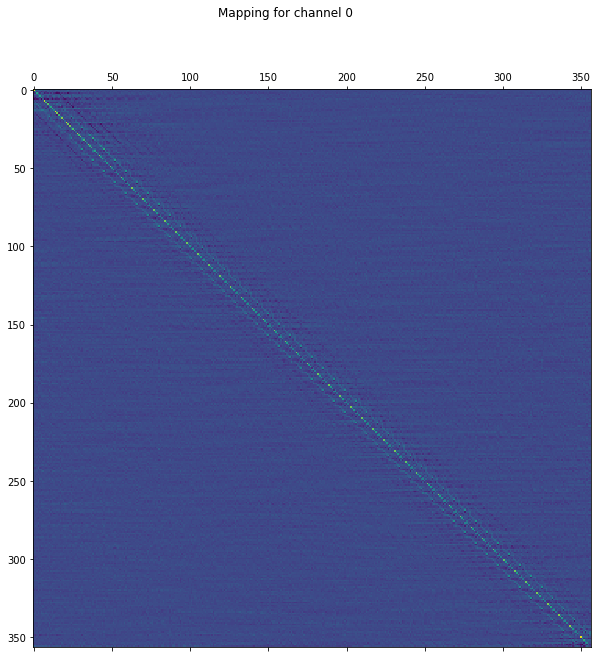

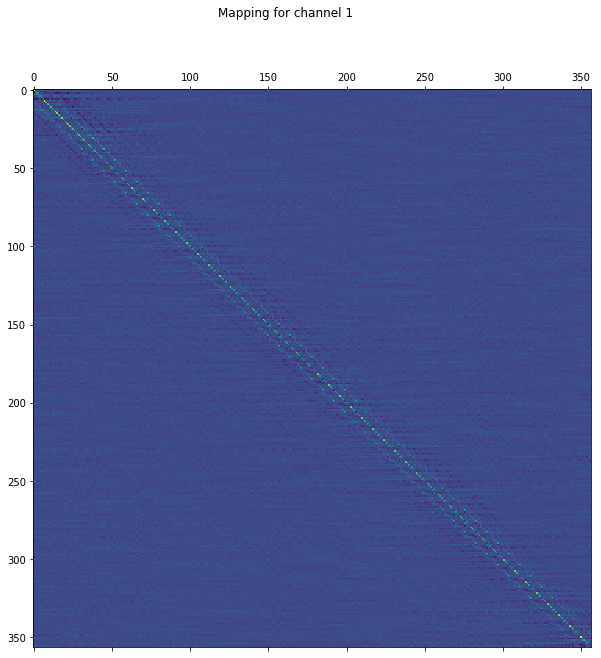

In [32]:
for ch, a_mapping in mapping.items():
    plt.matshow(a_mapping)
    plt.suptitle(f'Mapping for channel {ch}')

In [33]:
from itertools import product

def make_toeplitz(m):
    """Takes the average of diagonals
    """
    n_diagonals = m.shape[0] - 1

    for i in range(n_diagonals):
        diag = m.diagonal(i)
        val = diag.mean()
        np.fill_diagonal(m[:, i:], val)

    for i in range(1, n_diagonals):
        diag = m.diagonal(-i)
        val = diag.mean()
        np.fill_diagonal(m[i:], val)


def slice_transformation(matrix, fn, offset=51):
    """Slices a matrix in non overlapping offset * offset windows and applies a function
    """
    matrix = matrix.copy()
    
    n_windows = int(matrix.shape[0] / offset)

    slices = [slice(i * offset, (i+1) * offset)  for i in range(n_windows)]
    p = product(slices, slices)

    for i, j in p:
        m = matrix[i, j]
        make_toeplitz(m)
    
    return matrix

## Enforce Toeplitz

Make the optimal mapping a toeplitz matrix, by going through every 51 x 51 (waveform length) non-overlapping window and taking the mean accross diagonals.

In [34]:
mapping_toeplitz = {}

for channel, a_mapping in mapping.items():
    mapping_toeplitz[channel] = slice_transformation(a_mapping, make_toeplitz)

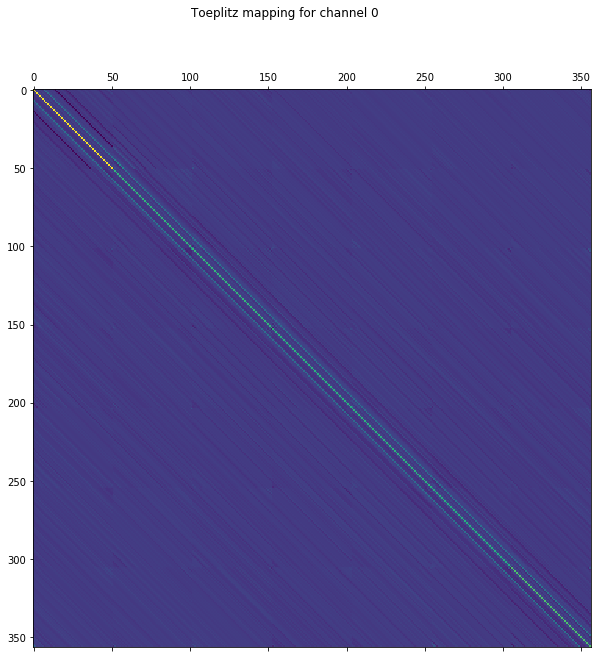

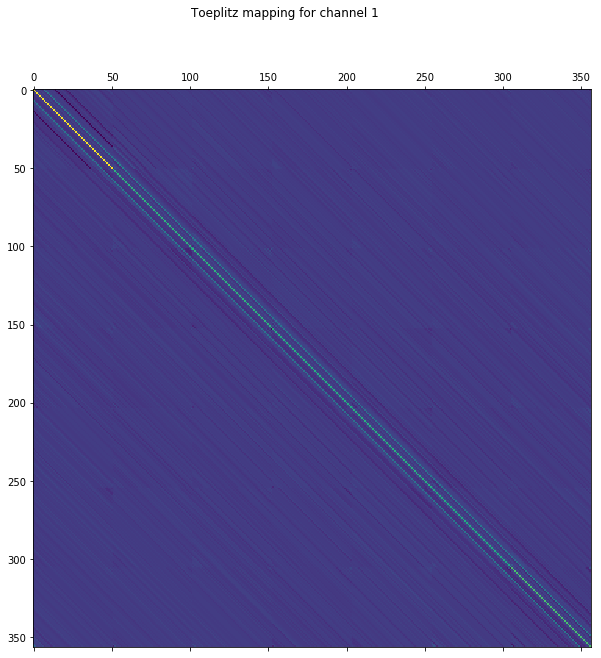

In [35]:
for ch, a_mapping in mapping_toeplitz.items():
    plt.matshow(a_mapping)
    plt.suptitle(f'Toeplitz mapping for channel {ch}')

In [36]:
# decide whether to use the toeplitz mapping or not
if USE_TOEPLITZ:
    denoiser = mapping_toeplitz
else:
    denoiser = mapping

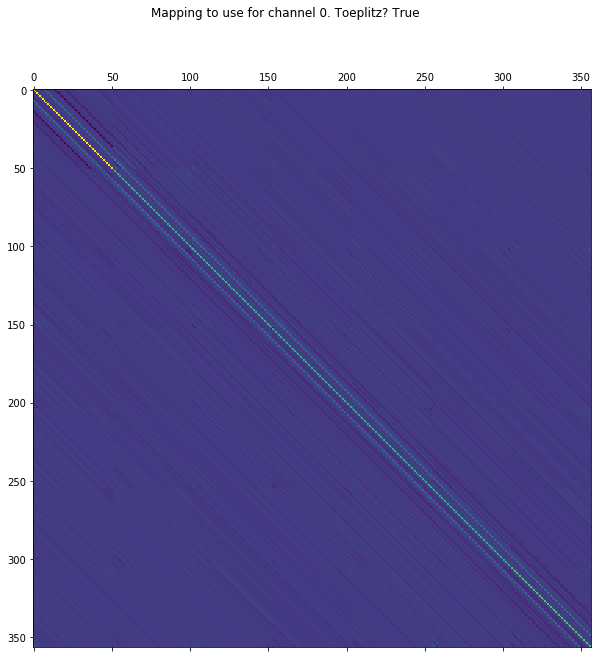

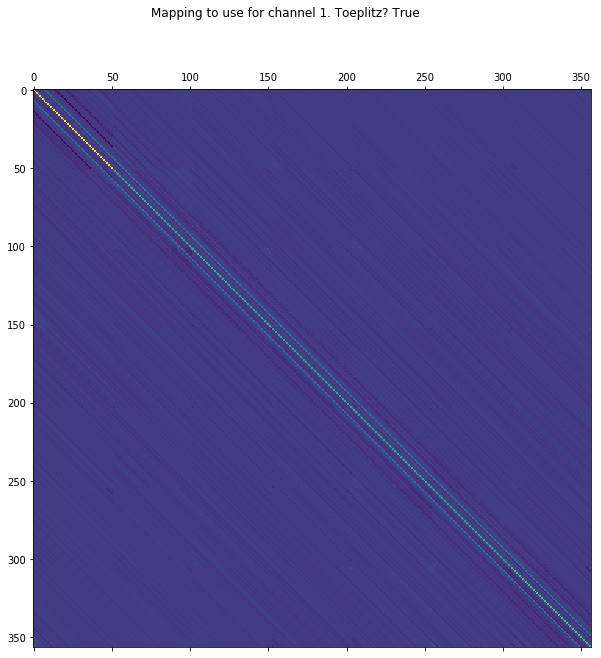

In [37]:
for ch, den in denoiser.items():
    plt.matshow(den)
    plt.suptitle(f'Mapping to use for channel {ch}. Toeplitz? {USE_TOEPLITZ}')

## Denoise recordings chunkwise

In [38]:
def create_chunks(recordings, n_chunks, window_size, offset):
    chunks_all = []
    
    n_observations, n_channels = recordings.shape

    for i in range(n_chunks):
        start = i * offset
        end = i * offset + window_size
        
        if end > n_observations:
            end = n_observations

            if end - start == window_size:
                chunk = recordings[start:end, :]
                chunks_all.append(chunk)

            break
        else:
            chunk = recordings[start:end, :]
            chunks_all.append(chunk)
    
    return np.stack(chunks_all)

def denoise_chunks(chunks, mapping):
    denoised = np.matmul(chunks.reshape(chunks.shape[0], -1), mapping).reshape(-1, 51, 7)
    return denoised

def unroll_chunks(chunks):
    return chunks.reshape(-1, 7)

In [39]:
n_chunks = 200000
max_idx = n_chunks * 51

rec_denoised = dict()

# denoise recordings
for channel in CHANNELS:
    print(f'denoising channel {channel}...')
    chunks = create_chunks(rec_all[:, ch_idx[channel]], n_chunks, 51, 51)
    denoised = denoise_chunks(chunks, denoiser[channel])
    rec_denoised[channel] = unroll_chunks(denoised)

from yass.preprocess.batch import standarize

# re-scale denoised recordings
for ch in CHANNELS:
    print(f're-scaling channel {ch}')
    stds = standarize._standard_deviation(rec_denoised[ch], CONFIG.recordings.sampling_rate)
    rec_denoised[ch] = np.divide(rec_denoised[ch], stds)

denoising channel 0...
denoising channel 1...
re-scaling channel 0
re-scaling channel 1


## Visualize spikes in raw vs denoised

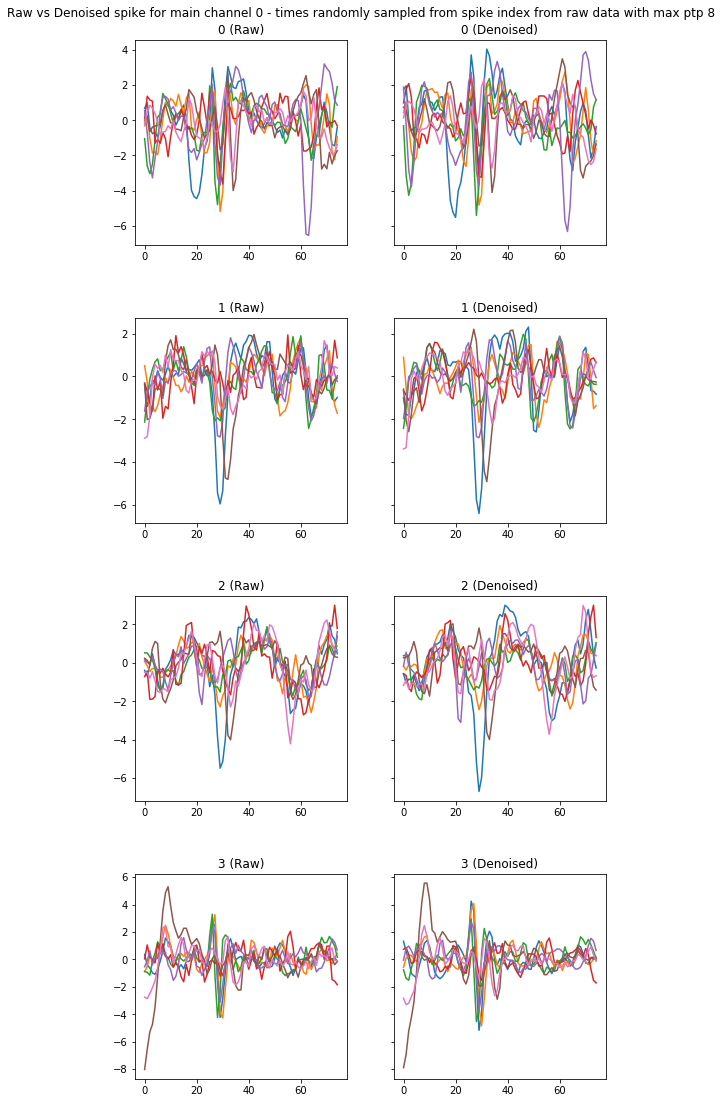

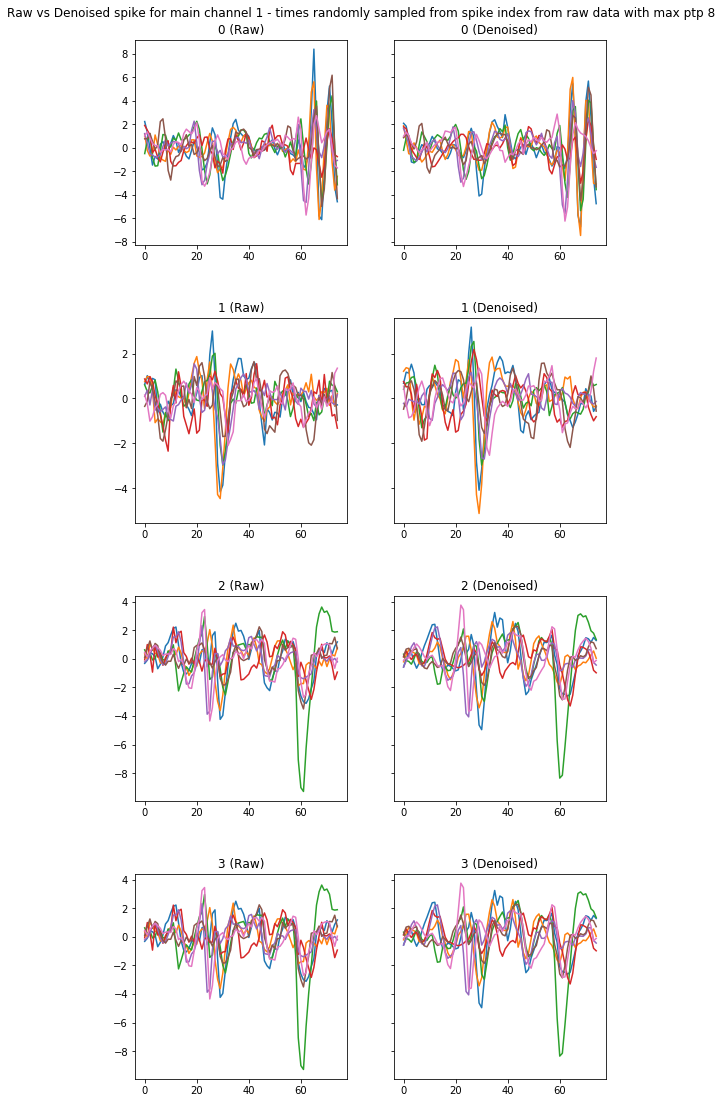

In [42]:
# FIXME: do times returned by the detector are the center?????

n_snippets = 3
max_ptp = 8

def make_random_slice(n_obs, length=200):
    max_idx = n_obs - length
    start = np.random.randint(max_idx)
    s = slice(start, start + length)
    return s

def make_slices(times, n_snippets=4, length=51):
    length_half = int(length/2)
    times_selected = np.random.choice(times, size=4)
    s = [slice(t -  length_half*2, t + length_half) for t in times_selected]
    return s

# slices = [make_random_slice(rec_all.shape[0]) for _ in range(n_snippets)]

def load_slice(s, ch, rec_all, ch_idx, rec_denoised):
    # get slice from raw recordings but only in selected channels
    raw = rec_all[s, ch_idx[ch]]
    # get denoised recs for the given channel
    denoised = rec_denoised[ch][s]
    
    return raw, denoised

# for ch in CHANNELS:
#     snippets = [load_slice(s, ch, rec_all, ch_idx, rec_denoised) for s in slices]
#     raw, denoised = zip(*snippets)
#     raw = np.stack(raw, axis=0)
#     denoised = np.stack(denoised, axis=0)
    
#     plot.grid_from_array([raw, denoised], axis=0, group_names=['Raw', 'Denoised'],
#                      sharey='row')
#     _ = plt.suptitle(f'Raw vs Denoised snippet for main channel {ch}')
#     plt.tight_layout(pad=3)


for ch in CHANNELS:
    times_all = indexes_raw.all.get_times_from_channel(ch, max_ptp=max_ptp,
                                                       rec=rec_all[:, ch_idx[ch]])

    slices = make_slices(times_all, n_snippets=n_snippets, length=51)

    snippets = [load_slice(s, ch, rec_all, ch_idx, rec_denoised) for s in slices]

    raw, denoised = zip(*snippets)
    raw = np.stack(raw, axis=0)
    denoised = np.stack(denoised, axis=0)
    
    plot.grid_from_array([raw, denoised], axis=0, group_names=['Raw', 'Denoised'],
                     sharey='row', auto_figsize=4)
    _ = plt.suptitle(f'Raw vs Denoised spike for main channel {ch} - times randomly sampled from spike index '
                     f'from raw data with max ptp {max_ptp}')
    plt.tight_layout(pad=4)

## Dump denoised data

In [43]:
for ch in CHANNELS:
    # dump denoised data
    path = f'/tmp/denoised-{ch}.bin'
    print(f'Dumping denoised data for channel {ch} in {path}')
    rec_denoised[ch].tofile(path)

Dumping denoised data for channel 0 in /tmp/denoised-0.bin
Dumping denoised data for channel 1 in /tmp/denoised-1.bin


## Compare distribution

In [45]:
def detect_on_denoised_data(denoised_rec, ch):
    # path to denoised
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
    yass.set_config("../config/gcloud/49/default.yaml", 'denoised')
    CONFIG = read_config()
    
#     rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
#                             standarized_params_denoised['n_channels'],
#                             standarized_params_denoised['data_order'],
#                             loader='array')
#     rec_denoised.shape
    
    # run this just to get the whiten filter
    (_,#standarized_path,
     _,#standarized_params,
     whiten_filter) = (preprocess
                       .run(if_file_exists='skip'))
    
    # run detector on denoised data
    (index_clean_denoised_arr,
     index_all_denoised_arr) = nnet.run(standarized_path_denoised, standarized_params_denoised, whiten_filter,
                                      'overwrite', False,
                                       path_to_detector,
                                       autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')
    
    # detector is going to pass it through all the seven channels, we just care about the ones in the main
    # channel
    clean = lib.SpikeIndex(index_clean_denoised_arr).get_spike_index_for_channel(ch)
    all_ = lib.SpikeIndex(index_all_denoised_arr).get_spike_index_for_channel(ch)
    
    return SpikeIndexes(clean=clean, all=all_)


indexes_denoised = {}


for ch, denoised in rec_denoised.items():
    print(f'Detecting on denoised data from channel {ch}...')
    spike_indexes = detect_on_denoised_data(denoised, ch)
    indexes_denoised[ch] = spike_indexes

Detecting on denoised data from channel 0...


100%|██████████| 657/657 [00:14<00:00, 44.13it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


Detecting on denoised data from channel 1...


100%|██████████| 657/657 [00:15<00:00, 43.18it/s]
/home/Edu/yass/src/yass/neuralnetwork/model.py:110: UserWarning: Input waveform length (51) is larger than Network's (31) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only (31) middle observations for predition
  self.waveform_length))
/home/Edu/yass/src/yass/neuralnetwork/model.py:132: UserWarning: Input number of neighbors (19) is larger than Network's (7) loaded from: (/home/Edu/yass/src/yass/assets/models/triage-31wf7ch-15-Aug-2018@00-17-16.h5), using only first (7) neighbors for predition
  self.n_neighbors))


In [46]:
# get indexes from the raw data and subset by the channels of interest
indexes_raw_dict = {}

for ch in CHANNELS:
    clean = indexes_raw.clean.get_spike_index_for_channel(ch)
    all_ = indexes_raw.all.get_spike_index_for_channel(ch)
    indexes_raw_dict[ch] = SpikeIndexes(clean=clean, all=all_)

In [47]:
# compare indexes
for ch in CHANNELS:
    raw_all, raw_clean = indexes_raw_dict[ch].all.shape[0], indexes_raw_dict[ch].clean.shape[0]
    denoised_all, denoised_clean = indexes_denoised[ch].all.shape[0], indexes_denoised[ch].clean.shape[0]
    inc_clean = denoised_clean/raw_clean
    inc_all = denoised_all/raw_all
    
    print(f'Channel {ch}:\n\t* All: {raw_all} (raw), {denoised_all} (denoised) increase: {inc_all:.2f}x'
          f'\n\t* Clean: {raw_clean} (raw), {denoised_clean} (denoised) increase: {inc_clean:.2f}x')

Channel 0:
	* All: 17721 (raw), 31475 (denoised) increase: 1.78x
	* Clean: 1650 (raw), 4334 (denoised) increase: 2.63x
Channel 1:
	* All: 29250 (raw), 108586 (denoised) increase: 3.71x
	* Clean: 3756 (raw), 35429 (denoised) increase: 9.43x


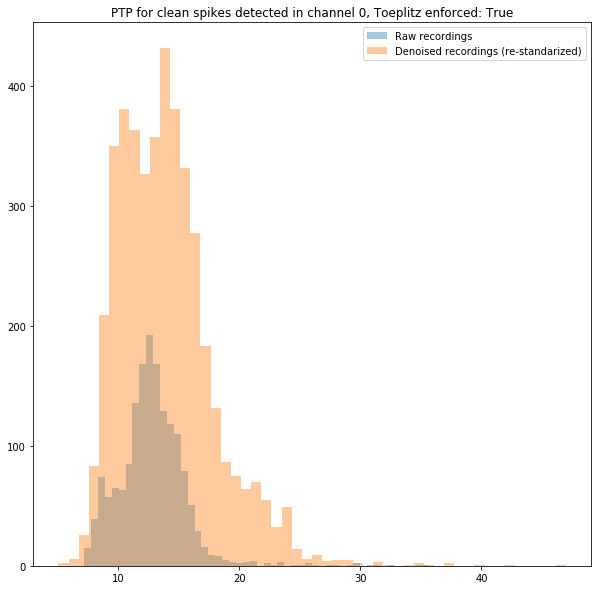

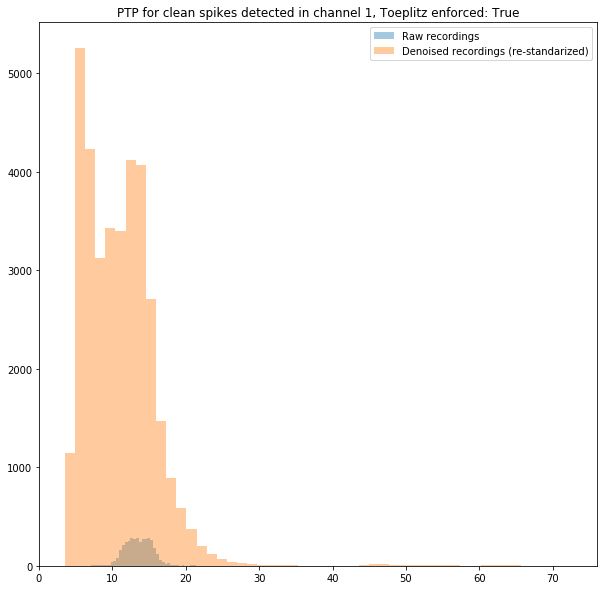

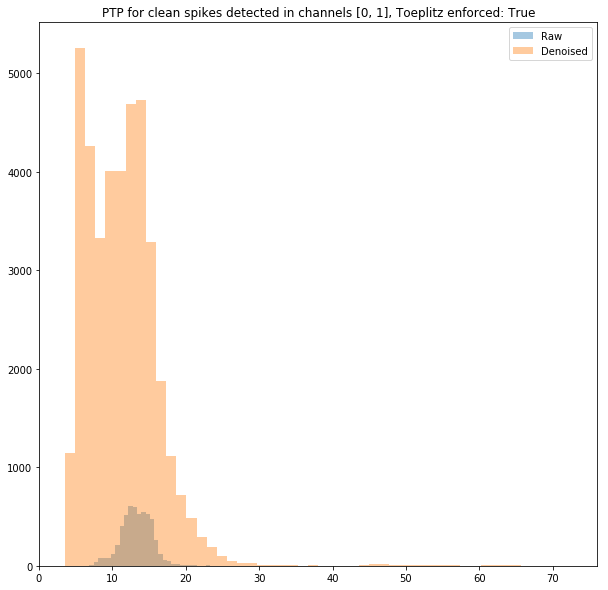

In [48]:
def plot_ptps(rec, spikes, ax=None, waveform_length=51, label=None, norm_hist=False, kde=False):
    wfs = lib.read_waveforms(rec, spikes, waveform_length=51)
    ptps = templates_utl.ptps(wfs)
    sns.distplot(ptps, ax=ax, label=label, norm_hist=norm_hist, kde=norm_hist)

    return ptps

ptps_raw = []
ptps_denoised = []

for ch in CHANNELS:
    plt.figure()
    
    # load raw recordings
    rec = rec_all[:, ch_idx[ch]]

    # load denoised
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
    rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                                    standarized_params_denoised['n_channels'],
                                    standarized_params_denoised['data_order'],
                                    loader='array').data

    raw = plot_ptps(rec, indexes_raw_dict[ch].clean.arr[:, 0], label='Raw recordings')
    # plot_ptps(rec, index_clean_denoised, label='Raw recordings, denoised spike index')
    denoised = plot_ptps(rec_denoised, indexes_denoised[ch].clean.arr[:, 0], label='Denoised recordings (re-standarized)')
    
    ptps_raw.append(raw)
    ptps_denoised.append(denoised)

    plt.legend()
    _ = plt.title('PTP for clean spikes detected in channel {}, Toeplitz enforced: {}'.format(ch, USE_TOEPLITZ))


ptps_raw = np.concatenate(ptps_raw, axis=0)
ptps_denoised = np.concatenate(ptps_denoised, axis=0)

plt.figure()
sns.distplot(ptps_raw, label='Raw', norm_hist=False, kde=False)
sns.distplot(ptps_denoised, label='Denoised', norm_hist=False, kde=False)
plt.legend()
_ = plt.title('PTP for clean spikes detected in channels {}, Toeplitz enforced: {}'.format(CHANNELS, USE_TOEPLITZ))

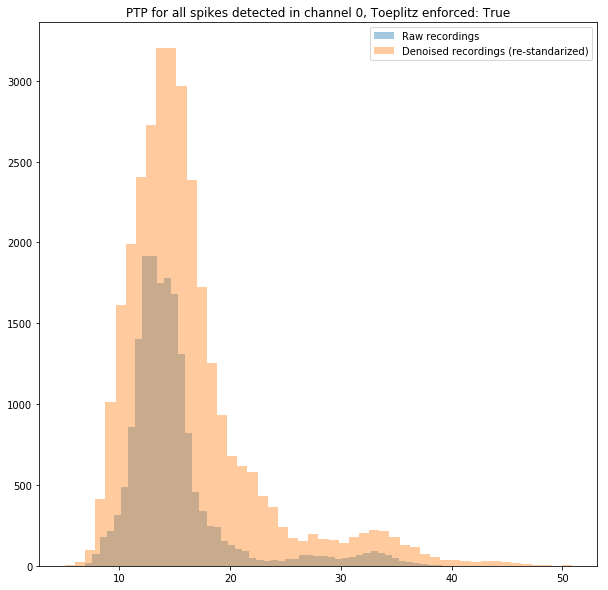

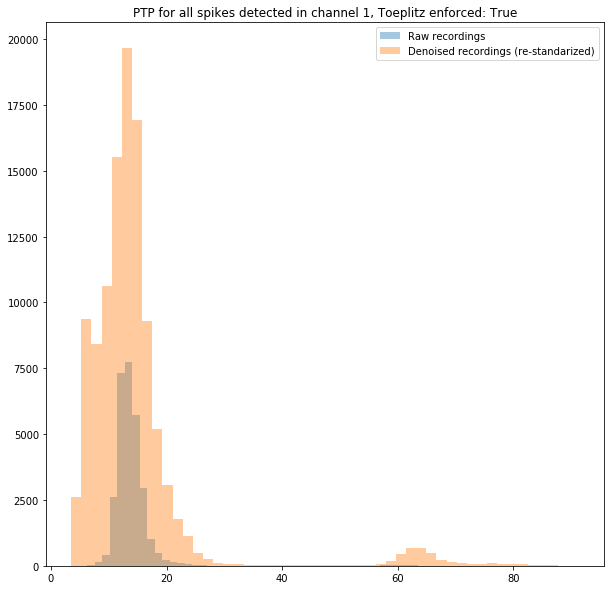

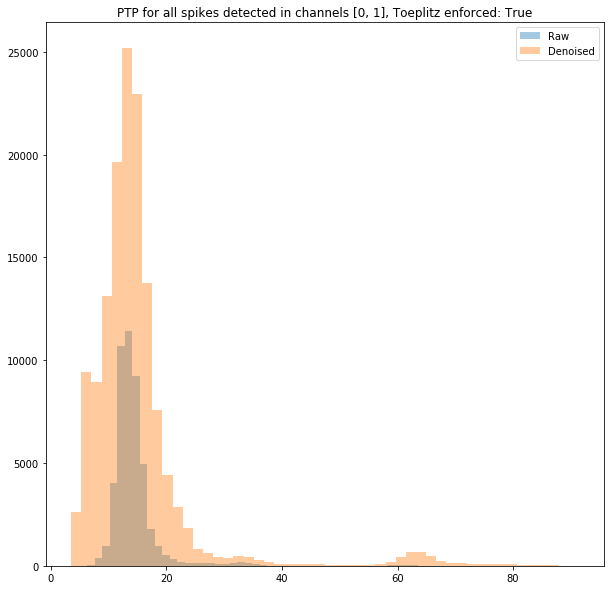

In [49]:
ptps_raw = []
ptps_denoised = []

for ch in CHANNELS:
    plt.figure()

    rec = rec_all[:, ch_idx[ch]]
    
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
    rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                                    standarized_params_denoised['n_channels'],
                                    standarized_params_denoised['data_order'],
                                    loader='array')

    # plot_ptps(rec, index_clean_denoised, label='Raw recordings, denoised spike index')
    raw = plot_ptps(rec, indexes_raw_dict[ch].all.arr[:, 0], label='Raw recordings')
    denoised = plot_ptps(rec_denoised, indexes_denoised[ch].all.arr[:, 0], label='Denoised recordings (re-standarized)')

    ptps_raw.append(raw)
    ptps_denoised.append(denoised)

    plt.legend()
    _ = plt.title('PTP for all spikes detected in channel {}, Toeplitz enforced: {}'.format(ch, USE_TOEPLITZ))

    
ptps_raw = np.concatenate(ptps_raw, axis=0)
ptps_denoised = np.concatenate(ptps_denoised, axis=0)

plt.figure()
sns.distplot(ptps_raw, label='Raw', norm_hist=False, kde=False)
sns.distplot(ptps_denoised, label='Denoised', norm_hist=False, kde=False)
plt.legend()
_ = plt.title('PTP for all spikes detected in channels {}, Toeplitz enforced: {}'.format(CHANNELS, USE_TOEPLITZ))

In [50]:
# test on noise

In [51]:
# test on templates

In [62]:
import pickle

# read waveforms from denoised and raw recordings
def load_denoised(ch):
    standarized_path_denoised = f'/tmp/denoised-{ch}.bin'
    standarized_params_denoised = {'data_order': 'samples', 'dtype': 'float64', 'n_channels': 7}
        
    rec_denoised = RecordingsReader(standarized_path_denoised, standarized_params_denoised['dtype'],
                            standarized_params_denoised['n_channels'],
                            standarized_params_denoised['data_order'],
                            loader='array')
    return rec_denoised

if SAVE_RESULTS:
    wfs = []

    for ch in CHANNELS:
        idx = indexes[ch].clean
        rec = load_denoised(ch)
        w = read_waveforms(rec, idx, waveform_length=51)
        wfs.append(w)

    wfs = np.concatenate(wfs, axis=0)
    
    np.save('/tmp/wfs-clean-denoised.npy', wfs)
    
    wfs = []
    
    for ch in CHANNELS:
        idx = indexes_raw[ch].clean
        rec = rec_all[:, ch_idx[ch]]
        w = read_waveforms(rec, idx, waveform_length=51)
        wfs.append(w)

    wfs = np.concatenate(wfs, axis=0)
    
    np.save('/tmp/wfs-clean-raw.npy', wfs)

    with open('/tmp/denoiser.pickle', 'wb') as f:
        pickle.dump(denoiser, f)